In [4]:
import numpy as np
import pandas as pd

### Input Data

In [5]:
SG = 0.65 #Native Gas
Gp_c = 6.2e6 #MSCF
Th = 70+460
Tr = 150+460

Ph_c = 500
Ph_d = 1250

grad_p = 0.65 #psi/ft

### Backpressure Data

In [6]:
dPsq = 295000 #psia2
Qg = 1000 #MSCFD

In [7]:
dt = 2+7/8 #ID
rough = 0.0006 #eps/d
L = 2600 #ft
theta = 0 #deg
fM = (1/(1.74-2*np.log10(2*rough)))**2

### A

In [8]:
Ppc = 709.604 - 58.718*SG
Tpc = 170.491 + 307.344*SG

In [9]:
def z(Ppr,Tpr):
    Az = 1.39*(Tpr-0.92)**0.5-0.36*Tpr-0.1
    Cz = 0.132 - 0.32*np.log10(Tpr)
    Ez = 9*(Tpr-1)
    Fz = 0.3106 - 0.49*Tpr+0.1824*Tpr**2
    Dz = 10**Fz
    Bz = (0.62-0.23*Tpr)*Ppr +(0.066/(Tpr-0.86)-0.037)*Ppr**2+0.32*Ppr**6/10**Ez

    z = Az + (1-Az)/np.exp(Bz) + Cz * Ppr**Dz
    return z
def obj_func(Pwfg,Ph):
    P_av = (Ph+Pwfg)/2
    Ppr_n = P_av/Ppc

    T_av = (Th+Tr)/2
    Tpr_n = T_av/Tpc

    cos_th = np.cos(theta/57.3)

    z_av = z(Ppr_n,Tpr_n)

    s = 0.0375*SG*L*cos_th/(z_av*T_av)
    es = np.exp(s)
    obj = Pwfg**2-es*Ph**2-(0.000667*(es-1)*fM*(Qg**2)*(z_av**2)*(T_av**2))/(dt**5*cos_th)
    return obj

In [10]:
rt = []
for Phead in [Ph_c,Ph_d]:
    Ph = Phead
    a = Ph
    b = 2500
    fa = obj_func(a,Ph)
    fb = obj_func(b,Ph)

    cprev = 2*b-a
    c = a - fa*(b-a)/(fb-fa)
    fc = obj_func(c,Ph)

    eps = 1e-6
    while abs(fc)>eps:
        if fa*fc<0:
            b = c
            fb = fc
        else:
            a = c
            fa = fc
        cprev = c
        c = a - fa*(b-a)/(fb-fa)
        fc = obj_func(c,Ph)
    rt = rt + [cprev]
Pwf = np.asarray(rt)

In [11]:
Pwf

array([ 532.58397538, 1335.75257661])

In [12]:
poverz = Pwf/z(Pwf/Ppc,Tr/Tpc)
poverz

array([ 561.0833232 , 1521.77252877])

In [13]:
gp = np.array([Gp_c,0])

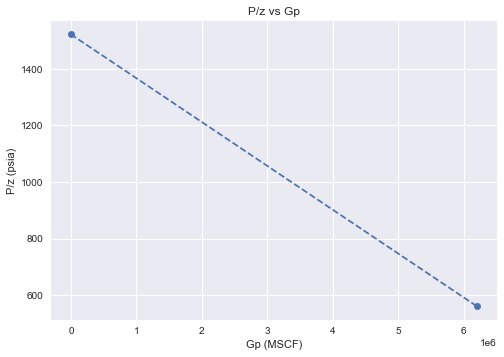

In [31]:
import matplotlib.pyplot as plt
plt.style.use("seaborn")
plt.plot(gp,poverz,"--o")
plt.title("P/z vs Gp")
plt.xlabel("Gp (MSCF)")
plt.ylabel("P/z (psia)")
plt.show()

In [32]:
#Gas Inplace and Current Gas Inplace
IGIP = (0-poverz[0])/((poverz[1]-poverz[0])/(gp[1]-gp[0]))+gp[0]
CGIP = IGIP - Gp_c
IGIP/1e6,CGIP/1e6

(9.821063486157849, 3.6210634861578495)

### B

In [33]:
H_top = 2562 #ft
P_top = grad_p*H_top

In [34]:
poverz_top = P_top/z(P_top/Ppc,Tr/Tpc)
poverz_top

1944.2813398184608

In [35]:
Ph_sf = 250*1.07
poverz_sf = Ph_sf/z(Ph_sf/Ppc,Tr/Tpc)
poverz_sf

274.31972155627494

In [36]:
poverz_i = poverz[1]
WS = IGIP*((poverz_top/poverz_i)-(poverz_sf/poverz_i))
WS/1e6

10.777431424425917

In [37]:
IGIP*(poverz_top/poverz_i)/1e6

12.547808632566158

In [38]:
#Base Gas
RBS = IGIP*(poverz_sf/poverz_i)
RBS/1e6

1.7703772081402398

In [39]:
#Left Gas in Reservoir for 80% of Working Storage Capacity
LS = IGIP*poverz_top/poverz_i-WS*0.8
print(LS/1e6)

3.925863493025426


In [40]:
poverz_WS = LS*poverz_top/IGIP
poverz_WS

777.2053548907459

In [41]:
#Find Presure value in poverz_WS
Tpr = Tr/Tpc
a = 700
b = 850

fa = (poverz_WS-a/z(a/Ppc,Tpr))
fb = (poverz_WS-b/z(b/Ppc,Tpr))

cprev = 2*b-a
c = a - fa*(b-a)/(fb-fa)
fc = (poverz_WS-c/z(c/Ppc,Tpr))

eps = 1e-5
while abs(fc)>eps:
    if fa*fc<0:
        b = c
        fb = fc
    else:
        a = c
        fa = fc
    cprev = c
    c = a - fa*(b-a)/(fb-fa)
    fc = (poverz_WS-c/z(c/Ppc,Tpr))
Pwh_WS = c

In [43]:
Pwh_WS

723.3101429071925

In [ ]:
#Minimum wellhead pressure for Withdrawal, Convert Pwh to Sandface Pressure
Pwh_sf_WS = Pwh_WS/1.07
round(Pwh_sf_WS,0)

In [ ]:
#1/30 Working Storage Capacity as Rate Withdrawal, MSCFD
Qd = WS/30
round(Qd/1e4,0)*1e4

In [ ]:
Q_bp = np.array([1000,2200,3800,5500])
Wells = np.round(Qd/Q_bp,0)

In [ ]:
dct = {
    "Pwh static (psia)" : np.zeros(len(Q_bp))+round(Pwh_sf_WS,0),
    "dPsq (psia^2)" : [295000,950000,2100000,4000000],
    "Flow Rate (MMscf/d)" : Q_bp*1e-3,
    "Wells for 360 MMscf/d" : Wells
}

df = pd.DataFrame(dct)
df

In [81]:
df.to_excel("PR 9.xlsx")